### 3.0 Load Data, Remove NaN & Outliers

In [1]:
import pandas as pd
import numpy as np

take_log_PTT = 0 # if not log, then all values are positive & the outliers are as defined
Remove_HR_Outliers = 1 # =1 if required more constraints on HR ( 54.4 < HR < 155.8) 
Remove_PTT_Outliers = 1
Remove_BP_Outliers = 1

Remove_PTTm_Outliers = 0 #(PATf)
Remove_PTTh_Outliers = 0 #(PPG Max-to-Min)


All_Instants_Data2 = pd.read_csv('Extracted_Instants_Parameters_8secWindow_PTTm_PTTh_MAP_210621.csv')
All_Instants_Data2.dropna(inplace=True)
All_Instants_Data = All_Instants_Data2

if take_log_PTT != 1:
    All_Instants_Data['PTT'] = np.exp(All_Instants_Data['PTT']) ################ NOT LOG ANYMORE # By commenting this, it is log
    All_Instants_Data['PTTm'] = np.exp(All_Instants_Data['PTTm'])

# Removing BP Outliers
if Remove_BP_Outliers == 1:
    cond_BP = ((All_Instants_Data['SBP']<180) & (All_Instants_Data['SBP']>80)) & ((All_Instants_Data['DBP']<130) & (All_Instants_Data['DBP']>60))
    All_Instants_Data= All_Instants_Data.loc[cond_BP, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

# Removing HR Outliers
if Remove_HR_Outliers == 1: 
    cond_HR = ((All_Instants_Data['HR']>54.4) & (All_Instants_Data['HR']<155.8))
    All_Instants_Data= All_Instants_Data.loc[cond_HR, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTT Ouliers (outlier if PTT>1.5) # So far, considering PTT<0.5 range gave the best result
if Remove_PTT_Outliers == 1: 
    cond_PTT = (All_Instants_Data['PTT']<0.4) #& (All_Instants_Data['PTT']>0.2)#& (All_Instants_Data['PTT']>.015) #### KEEP <0.4 only ##################
    All_Instants_Data= All_Instants_Data.loc[cond_PTT, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTm (PATf) Outliers
if Remove_PTTm_Outliers == 1: 
    cond_PTTm = ((All_Instants_Data['PTTm']>0.7) & (All_Instants_Data['PTTm']<1.5))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTm, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]
    
# Removing PTTh (PPG Max-to-Min) Outliers
if Remove_PTTh_Outliers == 1: 
    cond_PTTh = ((All_Instants_Data['PTTh']>1) & (All_Instants_Data['PTTh']<2))
    All_Instants_Data= All_Instants_Data.loc[cond_PTTh, ['PTTh','PTTm','PTT','HR','SBP', 'DBP','MAP']]

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np

TARGET = 'SBP' # SBP or DBP or MAP
temp_data = All_Instants_Data.loc[:, ['PTTh','PTTm','PTT','HR']]
train_copy2_tr, test_copy_tr, train_labels, test_labels = train_test_split(temp_data, All_Instants_Data[TARGET], test_size=0.2, random_state=42,shuffle=True)



In [19]:
from sklearn.linear_model import LinearRegression
import numpy as np

TARGET = 'SBP' # SBP or DBP or MAP
temp_data = All_Instants_Data.loc[:, ['PTTh','PTTm','PTT','HR']]
train_copy2_tr, test_copy_tr, train_labels, test_labels = train_test_split(temp_data, All_Instants_Data[TARGET], test_size=0.2, random_state=42,shuffle=True)


lin_reg = LinearRegression()
lin_reg.fit(train_copy2_tr, train_labels)    
Test_Predictions = lin_reg.predict(test_copy_tr)

Test_Error = test_labels - Test_Predictions

Test_ME = np.mean(Test_Error)

Test_std = np.std(Test_Error)
Test_MAE = np.mean(abs(Test_Error))

print('Test ME: ' + str(Test_ME) + '\n')
print('Test Std: ' + str(Test_std) + '\n')
print('Test MAE: ' + str(Test_MAE) + '\n')


Test ME: 0.07323293924852461

Test Std: 20.356507007643184

Test MAE: 16.702781188057045



In [20]:
import m2cgen as m2c
print(m2c.export_to_c(lin_reg))

double score(double * input) {
    return ((((144.7595952135736) + ((input[0]) * (5.560476637951604))) + ((input[1]) * (-0.8371734744260986))) + ((input[2]) * (-0.4882855887343618))) + ((input[3]) * (-0.22598764128164273));
}



In [21]:
import pandas as pd
C_Outputs = pd.DataFrame()
for i in range(len(test_copy_tr.index)):
    new_list = [test_copy_tr['PTTh'].iloc[i], test_copy_tr['PTTm'].iloc[i], test_copy_tr['PTT'].iloc[i], test_copy_tr['HR'].iloc[i]] 
    Pred = ((((144.7595952135736) + ((new_list[0]) * (5.560476637951604))) + ((new_list[1]) * (-0.8371734744260986))) + ((new_list[2]) * (-0.4882855887343618))) + ((new_list[3]) * (-0.22598764128164273))
    infTime = 1#C_list[1]
    Subset_DF = pd.DataFrame({'Pred':[Pred],'Inf_Time':[infTime]})
    C_Outputs = C_Outputs.append(Subset_DF, ignore_index=True)
    
    # Errors, ME, MAE, std Calculations:
    
Test_Error = test_labels - C_Outputs['Pred']
Test_ME = np.mean(Test_Error)
Inf_Times_avg = np.mean(C_Outputs['Inf_Time'])
Test_std = np.std(Test_Error)
Test_MAE = np.mean(abs(Test_Error))
print('Test ME: ' + str(Test_ME) + '\n')
print('Test Std: ' + str(Test_std) + '\n')
print('Test MAE: ' + str(Test_MAE) + '\n')

Test ME: 6.601343987688187

Test Std: 19.768411213102443

Test MAE: 16.926892850038335



In [ ]:
gcc -o LR.so -shared -fPIC -O2 LR.c
gcc -o SVM.so -shared -fPIC -O2 SVM.c
gcc -o DT.so -shared -fPIC -O2 DT.c
gcc -o RF.so -shared -fPIC -O2 RF.c

C:\Users\ahmedk1\.conda\envs\py371_sklearn0201\lib\site-packages\sklearn\linear_model\least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
C:\Users\ahmedk1\.conda\envs\py371_sklearn0201\lib\site-packages\sklearn\linear_model\least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.fi

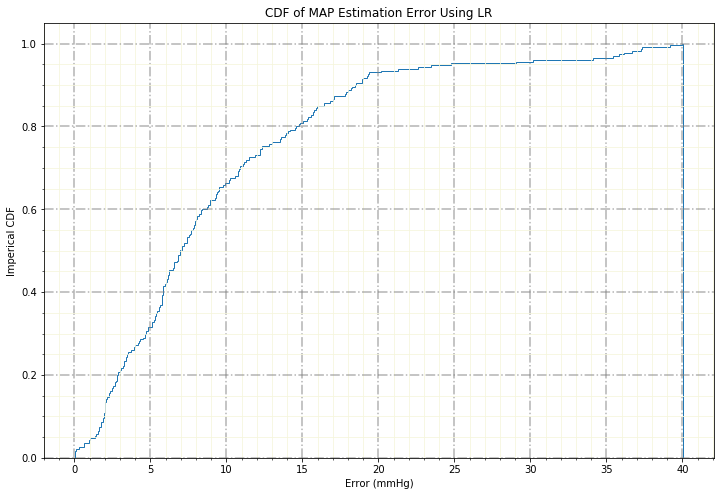

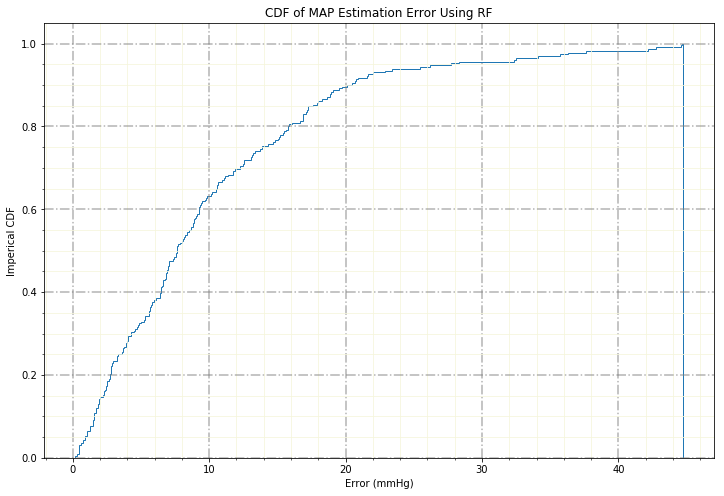

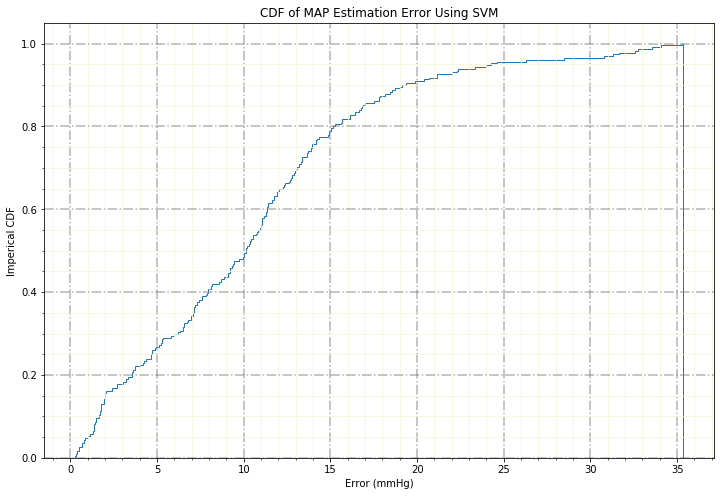

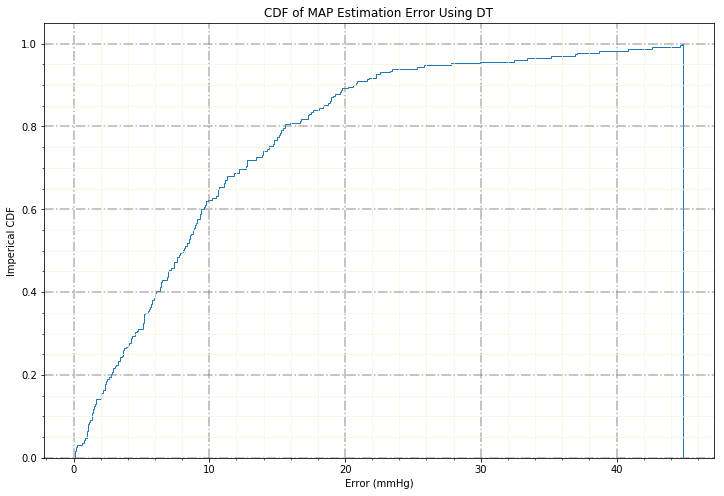

In [3]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from FilesfnCopy import RemoveGarbageEncodeObjects, display_scores
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from datetime import datetime
import m2cgen as m2c
import joblib # to save: joblib.dump(model, model_file) .. to load: xyz = joblib.load("model_name_as_saved.pkl")
#from LRt_module import LRt_c
from LR_module import LR_c
from SVM_module import SVM_c
from DT_module import DT_c
from RF_module import RF_c

TARGET = 'MAP' # SBP or DBP or MAP
Results_file = TARGET+'_Results_'+'.txt'

Reg_Model_vec = ['LR', 'RF', 'SVM', 'DT']

temp_data = All_Instants_Data.loc[:, ['PTTh','PTTm','PTT','HR']]
train_copy2_tr, test_copy_tr, train_labels, test_labels = train_test_split(temp_data, All_Instants_Data[TARGET], test_size=0.2, random_state=42,shuffle=True)


for Reg_Model in Reg_Model_vec:
    C_Outputs = pd.DataFrame()
    # Setting Models', Var's, Files', and Graphs' names to be saved
    
    CDF_file = TARGET + '_Error_CDF_' + Reg_Model + '.svg'
    Test_Error_file = TARGET + '_Test_Error_' + Reg_Model + '.pkl'

    if Reg_Model == "LR":
        for i in range(len(test_copy_tr.index)):
            new_list = [test_copy_tr['PTTh'].iloc[i], test_copy_tr['PTTm'].iloc[i], test_copy_tr['PTT'].iloc[i], test_copy_tr['HR'].iloc[i]] 
            C_list = LR_c(new_list)
            Pred = C_list[0]
            infTime = C_list[1]
            Subset_DF = pd.DataFrame({'Pred':[Pred],'Inf_Time':[infTime]})
            C_Outputs = C_Outputs.append(Subset_DF, ignore_index=True)

    if Reg_Model == "SVM":
        for i in range(len(test_copy_tr.index)):
            new_list = [test_copy_tr['PTTh'].iloc[i], test_copy_tr['PTTm'].iloc[i], test_copy_tr['PTT'].iloc[i], test_copy_tr['HR'].iloc[i]] 
            C_list = SVM_c(new_list)
            Pred = C_list[0]
            infTime = C_list[1]
            Subset_DF = pd.DataFrame({'Pred':[Pred],'Inf_Time':[infTime]})
            C_Outputs = C_Outputs.append(Subset_DF, ignore_index=True)
            
    if Reg_Model == "DT":
        for i in range(len(test_copy_tr.index)):
            new_list = [test_copy_tr['PTTh'].iloc[i], test_copy_tr['PTTm'].iloc[i], test_copy_tr['PTT'].iloc[i], test_copy_tr['HR'].iloc[i]] 
            C_list = DT_c(new_list)
            Pred = C_list[0]
            infTime = C_list[1]
            Subset_DF = pd.DataFrame({'Pred':[Pred],'Inf_Time':[infTime]})
            C_Outputs = C_Outputs.append(Subset_DF, ignore_index=True)
            
    if Reg_Model == "RF":
        for i in range(len(test_copy_tr.index)):
            new_list = [test_copy_tr['PTTh'].iloc[i], test_copy_tr['PTTm'].iloc[i], test_copy_tr['PTT'].iloc[i], test_copy_tr['HR'].iloc[i]] 
            C_list = RF_c(new_list)
            Pred = C_list[0]
            infTime = C_list[1]
            Subset_DF = pd.DataFrame({'Pred':[Pred],'Inf_Time':[infTime]})
            C_Outputs = C_Outputs.append(Subset_DF, ignore_index=True)
    
    
    # Errors, ME, MAE, std Calculations:
    
    Test_Error = test_labels - C_Outputs['Pred']
    Test_ME = np.mean(Test_Error)
    Inf_Times_avg = np.mean(C_Outputs['Inf_Time'])
    Test_std = np.std(Test_Error)
    Test_MAE = np.mean(abs(Test_Error))
    joblib.dump(Test_Error, Test_Error_file)
    
    # Writing Results in Text File: 
    textfile = open(Results_file, 'a')
    textfile.write('Results for ' + Reg_Model + '\n')
    textfile.write('Test ME: ' + str(Test_ME) + '\n')
    textfile.write('Test Std: ' + str(Test_std) + '\n')
    textfile.write('Test MAE: ' + str(Test_MAE) + '\n')
    textfile.write('Average Inference Time: ' + str(Inf_Times_avg) + '\n')
    textfile.write('=========================================' + '\n')
    textfile.close()
    
    # Plot & Save CDF of Error
    fig, ax = plt.subplots(figsize=(12, 8));
    ax.hist(abs(Test_Error), 500, density=1, histtype='step', cumulative=True, label='Empirical');
    plt.grid(b=True, which='major', color='gray', alpha=0.6, linestyle='dashdot', lw=1.5)
    #minor grid lines
    plt.minorticks_on()
    plt.xlabel('Error (mmHg)')
    plt.ylabel('Imperical CDF')
    plt.title('CDF of %s Estimation Error Using %s' %(TARGET, Reg_Model))
    plt.grid(b=True, which='minor', color='beige', alpha=0.8, ls='-', lw=1)
    plt.savefig(CDF_file, format='svg', dpi=1200)
    

In [ ]:
mainfn(){
#include <string.h>
float PTT = 0.0;
float PTTm = 0.0;
float PTTh = 0.0;
float HR = 0.0; 
float Pred = 0.0;

unsigned long startMicros;
unsigned long totMicros;

char inputBuffer[] = // THIS SHOULD BE THE INPUT STRING FROM THE PYTHON CODE
parseData();


startMicros = micros();
PredictBP();
InfTime = micros() - startMicros;

return strncat(strncat(str(Pred),','),str(InfTime))
}
//=============


void parseData() {

    // split the data into its parts
    
    char * strtokIndx; // this is used by strtok() as an index
    
    strtokIndx = strtok(inputBuffer, ","); // this continues where the previous call left off
    PTTh = atof(strtokIndx);     // convert this part to a float .. PTTh
    strtokIndx = strtok(NULL, ","); // this continues where the previous call left off
    PTTm = atof(strtokIndx);     // convert this part to a float .. PTTm
    strtokIndx = strtok(NULL, ","); // this continues where the previous call left off
    PTT = atof(strtokIndx);     // convert this part to a float .. PTT
    strtokIndx = strtok(NULL, ","); 
    HR = atof(strtokIndx);     // convert this part to a float .. HR

}

//=============
void PredictBP() {
	Pred = ((160.85850307659024) + ((PTT) * (-3.787763844588624))) + ((HR) * (-0.28774280257155976));
}

